# Redes Convolucionales

En este Notebook se llevará acabo el entrenamiento de un modelo de Red Neuronal utilizando Redes Convolcuionales. El objetivo principal es familiarizarse con las redes neuronales convolucionales.


# CIFAR-10 Dataset

El conjunto de datos CIFAR-10 es un conjunto de datos popular utilizado para entrenar y evaluar algoritmos de aprendizaje automático para la clasificación de imágenes. Consiste en 60,000 imágenes a color de 32x32 píxeles, divididas en 10 clases: avión, automóvil, pájaro, gato, ciervo, perro, rana, caballo, barco y camión. Hay 6,000 imágenes por clase, con 50,000 imágenes para entrenamiento y 10,000 imágenes para pruebas.


En este ejercicio entrenaremos el mismo modelo de red neuronal en dos escenarios:

1. Escenario con muchos datos
2. Escenario con pocos datos

Lo anterior nos permitirá entender la importancia de los modelos pre-entrenados (¡que veremos la siguiente sesión!)


# Descarga de Información

Los datos de CIFAR-10 se encuentran en [`TensorFlow Datasets`](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data) y se puede acceder a ellos utilizando el método `load_data()`. 

In [1]:
pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Part 1: Building a Convolutional Neural Network from scratch using TensorFlow

# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import datasets, models
import matplotlib.pyplot as plt
import numpy as np
import visualkeras


(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

Una vez cargada la información, procedemos a visualizar el conjunto de datos. 

In [7]:
def plot_cifar10_classes():
    # Load the CIFAR-10 dataset
    (train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

    # Map class indices to class names
    class_names = {
        0: 'airplane',
        1: 'automobile',
        2: 'bird',
        3: 'cat',
        4: 'deer',
        5: 'dog',
        6: 'frog',
        7: 'horse',
        8: 'ship',
        9: 'truck'
    }

    # Combine training images and labels for shuffling
    data = list(zip(train_images, train_labels))

    # Shuffle the data
    np.random.shuffle(data)

    # Initialize an empty array to store an image from each class
    class_images = np.zeros((10, 32, 32, 3), dtype=np.uint8)

    # Iterate over the shuffled data
    for image, label in data:
        if np.sum(class_images) == 10 * 32 * 32 * 3:
            break

        if np.sum(class_images[label]) == 0:
            class_images[label] = image

    # Plot an image from each class
    fig, axs = plt.subplots(2, 5, figsize=(12, 6))
    fig.suptitle('CIFAR-10 Classes')

    for i in range(10):
        row = i // 5
        col = i % 5
        ax = axs[row, col]
        ax.imshow(class_images[i])
        ax.set_title(class_names[i])
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to plot the CIFAR-10 classes


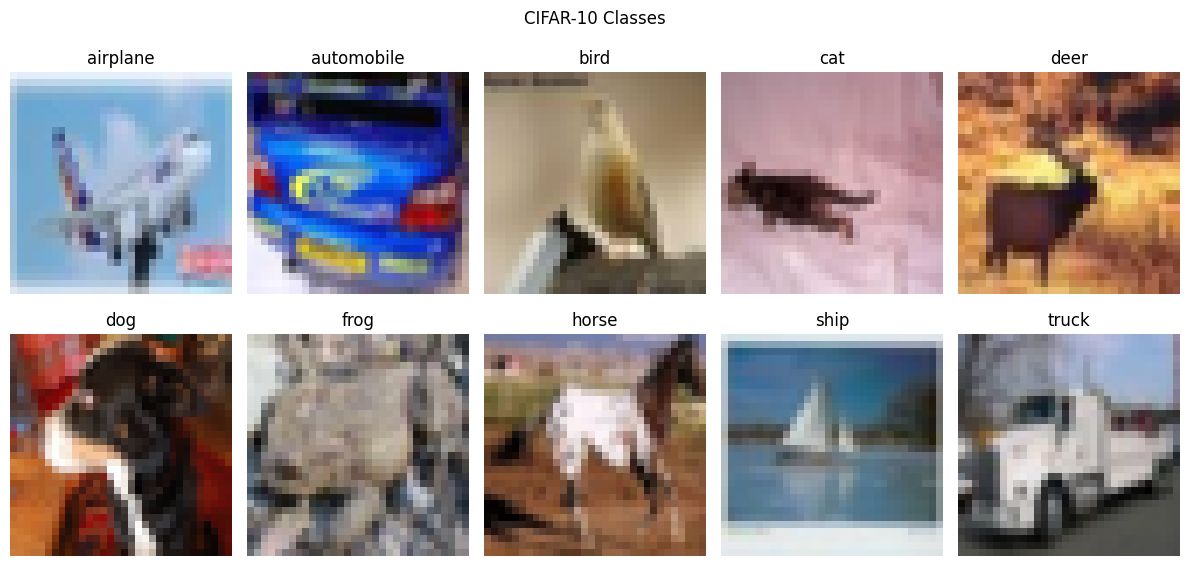

In [8]:
plot_cifar10_classes()


Se puede apreciar que en efecto existen 10 categorías y que las imágenes son de tamaño reducido. 

Antes de entrenar nuestro modelo de Red Neuronal, debemos normalizar nuestros datos. Como se trata de imágenes RGB, cada canal tendrá un valor máximo de 255 (intensidad máxima de R, G o B). 

In [9]:
### Normalice las imágenes de entrenamiento y prueba dividiendo por 255
train_images, test_images = train_images / 255.0, test_images / 255.0
###

In [10]:
# Realizamos división en valdiación también
from sklearn.model_selection import train_test_split
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [47]:
def plot_prediction_results(model, num_pixels = None):
    # Load the CIFAR-10 dataset
    (_, _), (test_images, test_labels) = datasets.cifar10.load_data()
    if num_pixels:
      original_shape = test_images.shape
      test_images = test_images.reshape(test_images.shape[0], num_pixels)

    # Normalize the test images
    test_images = test_images.astype('float32') / 255

    # Get predictions from the model
    predictions = model.predict(test_images)
    predicted_labels = np.argmax(predictions, axis=1)

    if num_pixels:
      test_images = test_images.reshape(original_shape)

    # Map class indices to class names
    class_names = {
        0: 'airplane',
        1: 'automobile',
        2: 'bird',
        3: 'cat',
        4: 'deer',
        5: 'dog',
        6: 'frog',
        7: 'horse',
        8: 'ship',
        9: 'truck'
    }

    # Plot random image, predicted label, true label, and prediction probability
    num_plots = 10
    fig, axs = plt.subplots(2, 5, figsize=(12, 8))
    fig.suptitle('Prediction Results')

    # Get shuffled indices for unique image selection
    indices = np.arange(len(test_images))
    np.random.shuffle(indices)

    for i in range(num_plots):
        row = i // 5
        col = i % 5
        ax = axs[row, col]

        # Select a unique test sample
        index = indices[i]
        image = test_images[index]
        true_label = test_labels[index][0]
        predicted_label = predicted_labels[index]
        prediction_probability = predictions[index][predicted_label]

        # Set title color based on prediction correctness
        title_color = 'green' if predicted_label == true_label else 'red'

        # Plot the image, labels, and probability
        ax.imshow(image)
        ax.set_title(f'Predicted: {class_names[predicted_label]}\nTrue: {class_names[true_label]}\nProbability: {prediction_probability:.4f}', color=title_color)
        ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


## Benchmark -- Simple Neural Network

Para evaluar la efectividad (o superioridad) de las Redes Neuronales Convolucionales, entrenaremos una red neuronal densa simple que ignora la dependencia espacial de los datos.

¿Recordamos el Flattenq ue hacíamos al comienzo? Bueno, en esta sección se debe aplicar una estrategia de reshaping, bues se tienen tres canales. R, G, y B. Cada canal tiene dimensión 32*32.

![Ejemplo Canales](https://i.stack.imgur.com/I4p5q.png)

En este caso, se debería hacer el flatten de cada imagen y concatenar verticalmente los vectores. 

Vamos paso a paso.


1. Determinar el tamaño del vector de cada canal
2. Sumar y determinar el tamaño del vector final
3. Hacer reshape de la imagen original en el tamaño del vector (ponerlo en una hillera)

El primer paso es sencillo, pues todos los canales tienen el mismo tamaño de imagen. Basta con encontrar uno para tener el tamaño de todos los vectores.

In [12]:
### Determina el Tamaño del vector para el canal rojo
### Pista: se calcula ancho por alto
ancho, alto = train_images.shape[1], train_images.shape[2]
vector_canal = ancho*alto
###

Una vez  se tiene `vector_canal` se conoce el número de pixeles que hay en total en cada canal. Por lo que el número de pixeles disponible sen la imagen es `vector_canal` multiplicado por el número de canales (en este caso, 3). 

In [13]:
### Encuentra el número total de pixeles informativos de la imagen
num_pixels = vector_canal*3
###

Basado en lo anterior, ya es posible realizar un reshape de las imágenes de entrenamiento y prueba, para que puedan ser utilizadas por la red neuronal simple. Utiliza el método [`reshape`](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html) para modificar el la dimensión de la imagen a un vector de tamaño `num_pixels`. 

In [20]:
### Reshape de imágenes de tran y test (asignar nuevo nombre...)

train_images_flatten =  train_images.reshape(train_images.shape[0], num_pixels)
val_images_flatten =  val_images.reshape(val_images.shape[0], num_pixels)
test_images_flatten =  test_images.reshape(test_images.shape[0], num_pixels)

###

¡Y ahora sí comienza lo bueno! 

Utilizando lo aprendido hasta el momento, crea un modelo de red neuronal densa (sencillo) para predecir la categoría de cada imagen. 

In [27]:
### Defina la arquitectura del modelo

simple_model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(512, input_dim=num_pixels, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')

])
###

In [42]:
### Complie el modleo
simple_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
###

Una vez definido y compilado el modelo, se puede realizar una visualización de la cantidad de parámetros que se van a entrenar. Utilice el método [`.summary()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#summary) para inspeccionar la arquitectura planteada.

In [29]:
simple_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 512)               1573376   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 10)               

Adicionalmente, utilizando la librería `visualkeras` puede entender gráficamente cómo es la red neuronal que planteó. 

In [30]:
visualkeras.layered_view(simple_model).show()

Una vez inspeccionado el modelo, entrénelo por 10 epochs (a modo de ejemplo. Pero puede utilizar muchas más si lo desea). No olvide incluir callbacks de EarlyStopping. No olvide incluir el dataset de valdiación.

In [31]:
simple_model

In [43]:
### Entrene su modelo
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history_simple = simple_model.fit(train_images_flatten, train_labels, epochs=20, 
                    validation_data=(val_images_flatten, val_labels), callbacks=[early_stopping])
###

1250/1250 [==============================] - 40s 31ms/step - loss: 1.8195 - sparse_categorical_accuracy: 0.3383 - val_loss: 1.7387 - val_sparse_categorical_accuracy: 0.3780


In [45]:
### Utilice el método `.evaluate` para determinar el desempeño del modelo en test 

test_loss, test_acc = simple_model.evaluate(test_images_flatten,  test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

###

313/313 - 3s - loss: 1.7252 - sparse_categorical_accuracy: 0.3899 - 3s/epoch - 10ms/step

Test accuracy: 0.38989999890327454


¿Cómo le dio al modelo? ¿Es un buen modelo?

In [ ]:
plot_prediction_results(simple_model, num_pixels)

## Red Convolucional

Una vez entrenado un modelo que ingora la información espacial que se encuentra en las imágenes, se realizará el entrenamiento de un modelo con redes neuronales convolucionales. 

Para esto recuerde que la arquitectura típica de una CNN es como sigue ![Arquitectura típica CNN](https://d33wubrfki0l68.cloudfront.net/a7664cf19de33b2c71a482629f27a0d70f715b77/6949d/images/blog/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way.jpg).

Utilice elemenso como:
- Convoluciones: [`Conv2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D), se sugiere kernel size `(3, 3)`. 
- Pooling Layers: [`MaxPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) o [`AveragePooling2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D) para el downsampling, se sugiere pool_size size `(2, 2)`.
- [`Flatten`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten)
- [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)

In [35]:
### Defina su modelo de Red Neuronal
model = models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation = 'softmax')
])

###


In [36]:
### Compile su modelo
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

###

In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)             

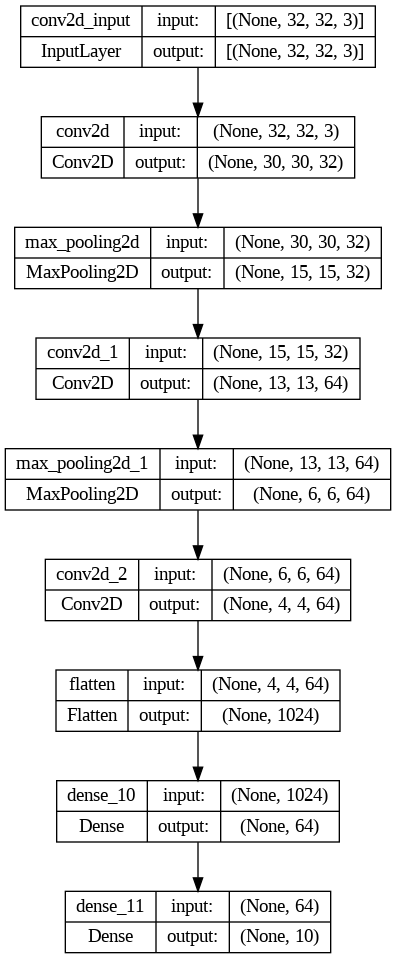

In [38]:
tf.keras.utils.plot_model(model, show_shapes=True)

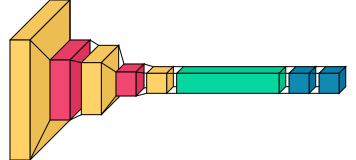

In [39]:
visualkeras.layered_view(model).show()

¡Y realice el entrenamiento del modelo! Nuevamente, se sugiere con 10 epochs para la clase, pero en su tiempo libre puede entrenarlo con más. 

In [40]:
### Entrene su modelo
history_model = model.fit(train_images, train_labels, epochs=20, batch_size = 128, 
                    validation_data=(test_images, test_labels),  callbacks=[early_stopping])

###

313/313 [==============================] - 73s 231ms/step - loss: 1.7064 - sparse_categorical_accuracy: 0.3759 - val_loss: 1.4536 - val_sparse_categorical_accuracy: 0.4781


A continuación, revise el desempeño de su modelo en Test. ¿Qué tal el accuracy? ¿Está satisfecho?

313/313 [==============================] - 5s 16ms/step


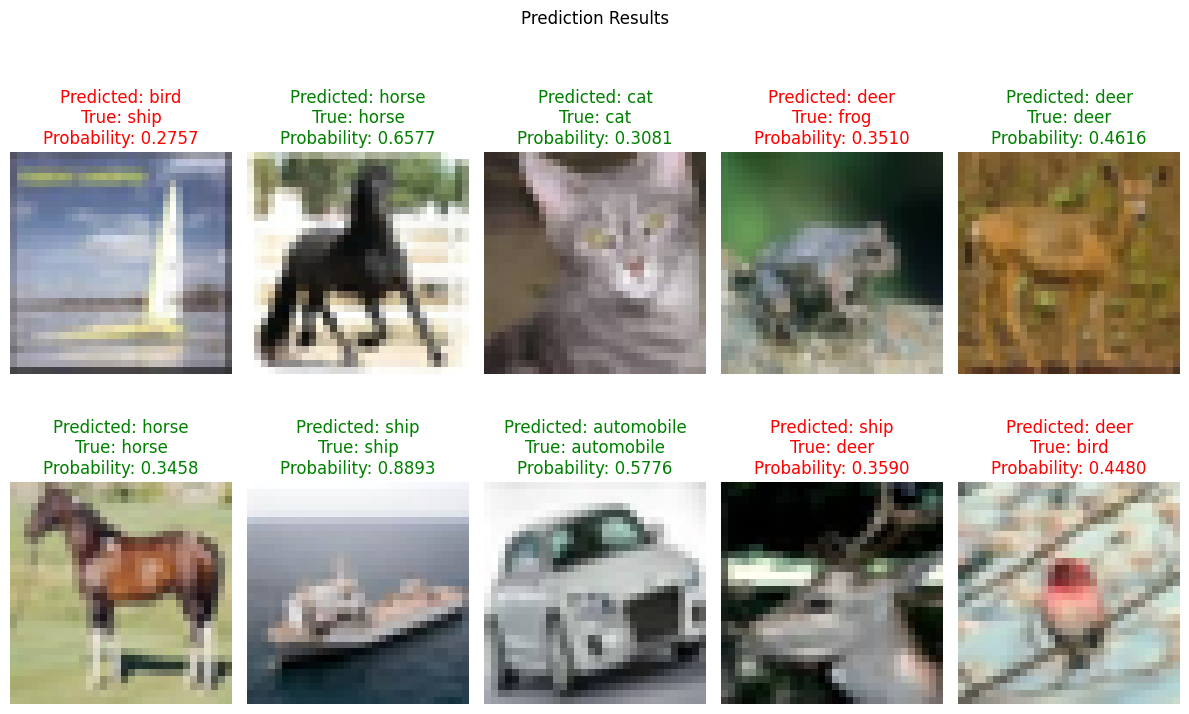

In [48]:
plot_prediction_results(model)

In [49]:
model.evaluate(test_images, test_labels)

313/313 [==============================] - 5s 17ms/step - loss: 1.4536 - sparse_categorical_accuracy: 0.4781


[1.4536192417144775, 0.4781000018119812]